<a href="https://colab.research.google.com/github/msiplab/EicEngLabIV/blob/develop/example02_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験Ⅳ－２　時系列データの分析

1. サンプルデータの読み込み
1. 平均 $\mu$ と分散 $\gamma_0$ の推定
1. 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

新潟大学工学部工学科　電子情報通信プログラム 

## 準備

In [25]:
!pip install bs4
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

from urllib import request
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import pandas.tseries.offsets as offsets
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定

## Webからの水位データの読み込み

新潟県河川防災情報システムより
http://doboku-bousai.pref.niigata.jp/kasen/index.html

河川ライブ映像 http://www.hrr.mlit.go.jp/shinano/live/map1.html# （小千谷市11番目）

以下のPythonライブラリを利用
- urllib
- bs4


In [37]:
# 水位観測所IDの設定
loc = '260' # 

# 解析期間の設定
dts = '2019072301' # 開始日時
dte = '2020072300' # 終了日時
interval = 1 # hour

# Webからの水位情報抽出
dts00 = pd.to_datetime(dts+'00')
dte00 = pd.to_datetime(dte+'00')
td = dte00 - dts00
durationinhours = int(td.total_seconds()/(3600))
t = [ [] for idx in range(durationinhours) ]
y = [ 0.0 for idx in range(durationinhours) ]
idt = dts00
idx = 0
while idt < dte00:
    # 水位抽出日時の設定
    strdt = idt.strftime('%Y%m%d%H%M')
    ts = pd.to_datetime(idt).tz_localize('Asia/Tokyo')

    # URLの設定
    url = 'http://doboku-bousai.pref.niigata.jp/kasen/servlet/bousaiweb.servletBousaiGraph?ga=4&gk=0&gn=0&gl=0&gw=0&go=0&omp=0&opn=0&spn=0&tvm=0&tsw=0&sv=3&dk=2&mp=0&no=0&fn=0&pg=6&sitept=0&unq=12062215494&nwg=0&tmg={0}&sn={1}&wsl=3&wl=1&rg=1&sy=gra_river&psn=0&=&nw=0&tm={0}&logflg=0'.format(strdt,loc)

    # 指定した時刻の水位情報抽出
    response = request.urlopen(url)
    soup = BeautifulSoup(response)
    response.close()
    if idt == dts00:
        strtitle = soup.title.text.strip()
    #print(soup.find('td', class_='tableHeaderCast').text.strip())
    strwaterlevel = soup.find('td', class_='tableHeaderItemCen').text.strip().replace('m','')
    try:
        waterlevel = float(strwaterlevel)
    except ValueError as ve:
        waterlevel = nan

    # リストへのデータ登録
    t[idx] = ts
    y[idx] = waterlevel

    # 時間を更新
    idx += 1
    idt += offsets.Hour(interval)


SyntaxError: invalid syntax (<ipython-input-37-f52748d5cf4e>, line 36)

## 時系列データをpandas.DataFrameオブジェクトに変換

pandas ライブラリの DataFrame オブジェクトに変換

- t: 時刻
- y: データの値


In [27]:
df_timeseries= pd.DataFrame({'t': t, 'y': y})
display(df_timeseries)

,t,y
0,2019-07-23 01:00:00+09:00,42.08
1,2019-07-23 02:00:00+09:00,42.07
2,2019-07-23 03:00:00+09:00,42.11
3,2019-07-23 04:00:00+09:00,42.10
4,2019-07-23 05:00:00+09:00,42.12
...,...,...
8778,[],0.00
8779,[],0.00
8780,[],0.00
8781,[],0.00


## 時系列データをプロット

- y: 原系列
- y_fillna: 欠損個所を前の値で補間


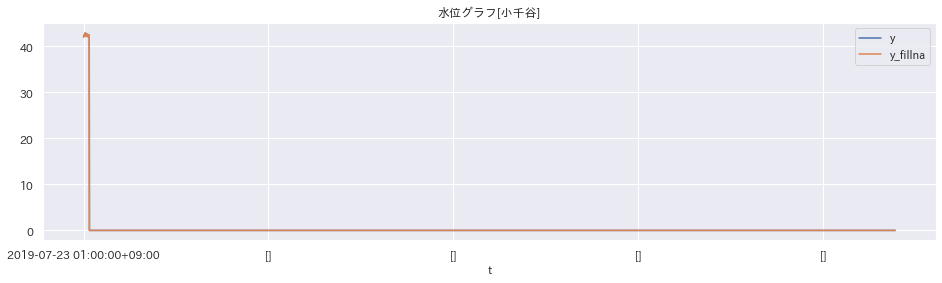

In [28]:
df_timeseries['y_fillna'] = df_timeseries['y'].fillna(method='ffill').astype(float) 
ax = df_timeseries.plot(x='t', y={'y', 'y_fillna'}, figsize=(16,4), title=strtitle)


ヒストグラムをプロット

Text(0.5, 1.0, '水位グラフ[小千谷]')

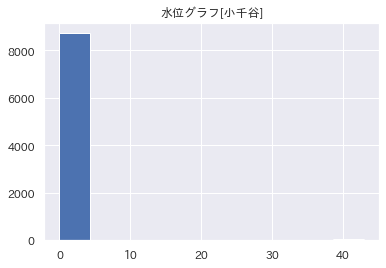

In [29]:
ax = df_timeseries.hist('y')
ax[0][0].set_title(strtitle)

## 平均 $\mu$ と分散 $\gamma_0$ の推定

- mean(): 標本平均を計算
- var(): 標本分散を計算

pandas.DataFrame オブジェクトのvar() メソッドのオプションで 

- ddof = 0 とすると N で割る最尤推定
- ddof = 1 とすると (N-1)で割る不偏推定 ※デフォルト

In [30]:
y_series = df_timeseries['y']
mu = y_series.mean()
gamma0 = y_series.var(ddof=1) 
print('平均 = {:f}, 分散 = {:f}'.format(mu,gamma0))

平均 = 0.303936, 分散 = 12.787961


## 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

y_series は pandas.Series のオブジェクトとなっている。
pandas.Seriesオブジェクトは以下のメソッドを備える。

- cov() は共分散の不偏推定を計算
- corr() は相関の不偏推定を計算

※不偏推定から最尤推定への切替はできない


In [31]:
nlags = 40
for lag in range(nlags+1):
    gammak = y_series.cov(y_series.shift(lag))
    rhok = y_series.corr(y_series.shift(lag))
    print('γ{0:d} = {1:f}, ρ{0:d} = {2:f}'.format(lag,gammak,rhok))

γ0 = 12.787961, ρ0 = 1.000000
γ1 = 12.588595, ρ1 = 0.992038
γ2 = 12.389088, ρ2 = 0.984001
γ3 = 12.188744, ρ3 = 0.975852
γ4 = 11.988164, ρ4 = 0.967617
γ5 = 11.787081, ρ5 = 0.959284
γ6 = 11.585658, ρ6 = 0.950868
γ7 = 11.383613, ρ7 = 0.942365
γ8 = 11.181714, ρ8 = 0.933852
γ9 = 10.979657, ρ9 = 0.925321
γ10 = 10.778134, ρ10 = 0.916759
γ11 = 10.576879, ρ11 = 0.908132
γ12 = 10.376168, ρ12 = 0.899442
γ13 = 10.175855, ρ13 = 0.890670
γ14 = 9.975991, ρ14 = 0.881802
γ15 = 9.776012, ρ15 = 0.872835
γ16 = 9.575271, ρ16 = 0.863748
γ17 = 9.372391, ρ17 = 0.854453
γ18 = 9.168438, ρ18 = 0.844995
γ19 = 8.963756, ρ19 = 0.835440
γ20 = 8.757812, ρ20 = 0.825759
γ21 = 8.551545, ρ21 = 0.815971
γ22 = 8.345852, ρ22 = 0.806112
γ23 = 8.141245, ρ23 = 0.796164
γ24 = 7.938669, ρ24 = 0.786139
γ25 = 7.736731, ρ25 = 0.776008
γ26 = 7.534864, ρ26 = 0.765709
γ27 = 7.332408, ρ27 = 0.755191
γ28 = 7.129718, ρ28 = 0.744502
γ29 = 6.926615, ρ29 = 0.733641
γ30 = 6.722964, ρ30 = 0.722623
γ31 = 6.518668, ρ31 = 0.711429
γ32 = 6.314400

## 時系列解析ライブラリ

時系列解析には，statsmodelsライブラリも利用できる。

- acovf() は自己共分散関数を計算
- acf() は自己相関関数を計算

各メソッドのオプション unbiased = True で不偏推定，Falseで最尤推定となる．



In [32]:
import statsmodels.api as sm
from statsmodels.tsa import stattools

#欠損値がある場合は nan が含まれる．
#欠損個所を補間したデータを使わない場合は以下の行をコメントアウトする
y_series = df_timeseries['y_fillna']

print('自己共分散関数')
y_acovf = stattools.acovf(y_series,unbiased=True)
display(y_acovf)
print('自己相関関数')
y_acf = stattools.acf(y_series,unbiased=True)
display(y_acf)


自己共分散関数


array([ 12.78650464,  12.58716179,  12.38767596, ..., -12.69927656,
       -12.69573064, -12.69725032])

自己相関関数


array([1.        , 0.9844099 , 0.96880862, 0.95314198, 0.93745677,
       0.92173226, 0.90598116, 0.89018133, 0.87439291, 0.85859211,
       0.84283309, 0.82709492, 0.81139931, 0.79573482, 0.78010536,
       0.76446693, 0.74876886, 0.73290348, 0.71695419, 0.70094788,
       0.68484285, 0.66871249, 0.65262702, 0.63662646, 0.62078475,
       0.60499282, 0.58920646, 0.57337401, 0.55752319, 0.54164006,
       0.5257141 , 0.50973764, 0.49376335, 0.47778299, 0.46184813,
       0.4459502 , 0.43007741, 0.41421446, 0.39838755, 0.38254472,
       0.36664195])

## 原系列のコレログラムの表示

自己相関のグラフをコレログラムとよぶ。コレログラムは次のコマンドで表示できる。

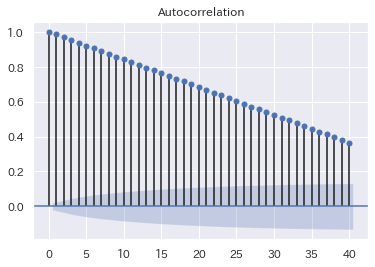

In [33]:
fig = sm.graphics.tsa.plot_acf(y_series,lags=nlags)

## 階差系列の分析

ひとつ前の値との差分をとった系列を階差系列とよぶ。

$\Delta y_n = y_{n} - y_{n-1}$


,t,y,y_fillna,y_diff
0,2019-07-23 01:00:00+09:00,42.08,42.08,NaN
1,2019-07-23 02:00:00+09:00,42.07,42.07,-0.01
2,2019-07-23 03:00:00+09:00,42.11,42.11,0.04
3,2019-07-23 04:00:00+09:00,42.10,42.10,-0.01
4,2019-07-23 05:00:00+09:00,42.12,42.12,0.02
...,...,...,...,...
8778,[],0.00,0.00,0.00
8779,[],0.00,0.00,0.00
8780,[],0.00,0.00,0.00
8781,[],0.00,0.00,0.00


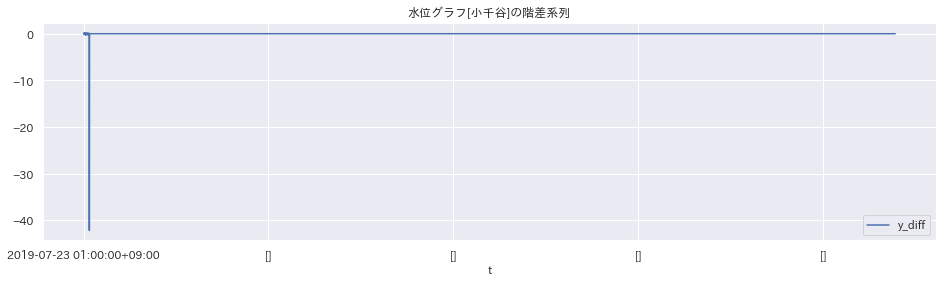

In [34]:
# 欠損データの補間を行わない場合
#df_timeseries['y_diff'] = df_timeseries['y'].diff()
# 欠損データを補間を行う場合
df_timeseries['y_diff'] = df_timeseries['y_fillna'].diff()
display(df_timeseries)
df_timeseries.plot(x='t', y='y_diff', figsize=(16,4), title='{}の階差系列'.format(strtitle))



ヒストグラムをプロット


Text(0.5, 1.0, '水位グラフ[小千谷]')

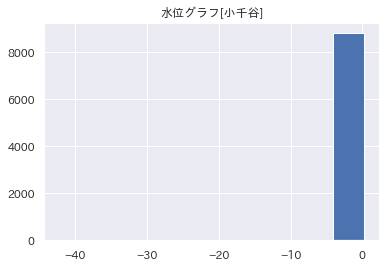

In [35]:
ax = df_timeseries.hist('y_diff')
ax[0][0].set_title(strtitle)

原系列 $y_n$ と階差系列 $\Delta y_n$ のCSVへの出力

In [36]:
df_timeseries.to_csv('./data/sample02_03.csv',index=False)